
<h1 style="display: inline;">Djinn Hands-On Workshop - Notes</h1><br>
November 30, 2022

In [1]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#!pip install catboost
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

random_state = 0

## The Dataset
<hr>

We will use a dataset from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) to predict customer churn - whether or not a customer has left the service in the last month - from a fictional telecom company, Telco. There are 7,032 rows in this dataset with each representing a customer and their characteristics captured in the 21 columns. These columns include a mix of numeric and categorical features. 

In [2]:
#reading in data
telco = pd.read_csv('telco_clean.csv')
telco.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   object 
 4   dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   phoneservice      7032 non-null   object 
 7   multiplelines     7032 non-null   object 
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   object 
 10  onlinebackup      7032 non-null   object 
 11  deviceprotection  7032 non-null   object 
 12  techsupport       7032 non-null   object 
 13  streamingtv       7032 non-null   object 
 14  streamingmovies   7032 non-null   object 
 15  contract          7032 non-null   object 
 16  paperlessbilling  7032 non-null   object 


## Goal 
<hr>

We want to predict whether or not a customer will Churn (whether or not a customer will leave the service) within the next month. This could allow telco to target these customers with more promotional material or customer service reps reaching out to engage more. To do this we will build a classification model.   

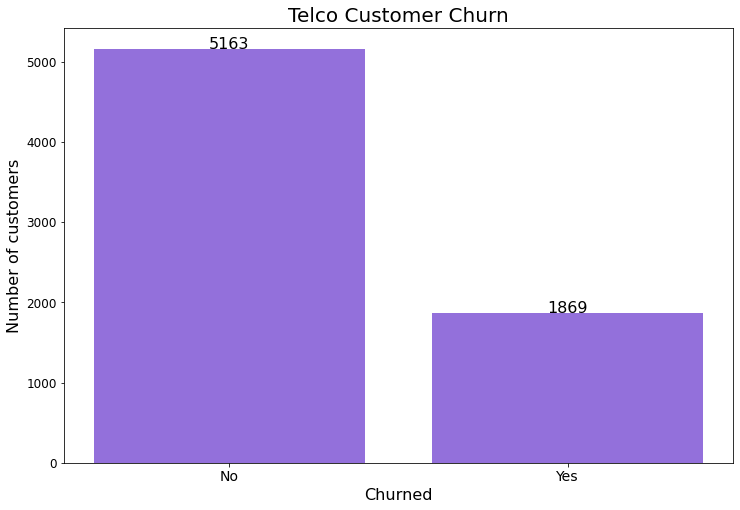

Proportions of customer churn:


No     0.734215
Yes    0.265785
Name: churn, dtype: float64

In [4]:
#distribution of customer churn
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', fontsize=16)

plt.figure(figsize=(12,8))
plt.bar(telco['churn'].unique(), telco['churn'].value_counts(), color='mediumpurple')
plt.title('Telco Customer Churn', fontsize=20)
plt.ylabel('Number of customers', fontsize=16)
plt.xlabel('Churned', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
addlabels(telco['churn'].unique(), telco['churn'].value_counts())
plt.show()

print('Proportions of customer churn:')
telco['churn'].value_counts(normalize=True)

There is a clear imbalance between customers who churned and did not churn in this datset with there being about 1/3 the customers who've churned versus not. To give our classification model equal opportunity to learn the patterns in each class, we will use Djinn to create synthetic data that mimics the real data to augment the minority class. 

## Using Djinn to Augment the Minority Class
<hr>

Since we are going to be modeling with our synthetic data from Djinn, we want to make sure that we are isolating our testing data from our Djinn model. This ensures that the characteristics of the test data don't bleed into the data the model is training on so we can get a true test.

Before using Djinn we will define our inputs and outputs as well as perform a train-test-split. 

In [5]:
#defining inputs and outputs
target = 'churn'
modeling_columns = [x for x in telco.columns if x != 'customerid']
input_columns = [x for x in modeling_columns if x != target]
categorical_columns = [x for x in modeling_columns if telco[x].dtype == 'object']

In [6]:
#splitting the data
#telco_train, telco_test = train_test_split(telco[modeling_columns], test_size=0.25, random_state=random_state)

#saving split data to CSVs to use with Djinn 
#telco_train.to_csv('telco_train.csv', index=False)
#telco_test.to_csv('telco_test.csv', index=False)

In [7]:
telco_train = pd.read_csv('telco_train.csv')
telco_test = pd.read_csv('telco_test.csv')

# Let's jump to [Djinn](https://djinn.tonic.ai/login?signup=true)!

We want to make sure that our data types are read in accurately, so we cast the numeric data to their correct datatypes in our SQL query.

```sql
SELECT
    gender,
    seniorcitizen,
    partner,
    dependents,
    cast(tenure as int),
    phoneservice,
    multiplelines,
    internetservice,
    onlinesecurity,
    onlinebackup,
    deviceprotection,
    techsupport,
    streamingtv,
    streamingmovies,
    contract,
    paperlessbilling,
    paymentmethod,
    cast(monthlycharges as float),
    cast(totalcharges as float),
    churn
FROM telco_train;
```

In [ ]:
api_token = 

### Pulling in Data from Djinn

In [ ]:
#code snippet


In [8]:
#calculating the number of samples needed to balance the data
n_samples = telco_train.shape[0]
n_churn = telco_train[telco_train['churn'] == 'Yes'].shape[0]
n_samples_needed = int((0.5 * n_samples - n_churn) / (1 - 0.5)) + 1 
f"We need {n_samples_needed} data points to balance churned customers to non-churned customers."


'We need 2431 data points to balance churned customers to non-churned customers.'

In [ ]:
#subsetting out data from churned customers
churn_samples = sample[sample['churn'] == 'Yes']
new_samples = churn_samples[:n_samples_needed]
original_samples = telco_train[modeling_columns].copy()

#adding our synthetic data to our original training data
new_model_train_data = pd.concat([original_samples, new_samples], axis=0).reset_index(drop=True)

#testing to ensure our datasets are balanced
new_model_train_data['churn'].value_counts(normalize=True)


## Modeling with Djinn data
<hr>

Now that our dataset is balanced, let's see how our data performs in a model. We are training a CatBoost model here as this model best fits the data. 

In [ ]:
#prepping djinn-augmented data for modeling
# split data into X&y
X_train_djinn = new_model_train_data[input_columns]
y_train_djinn = new_model_train_data[target]
X_test = telco_test[input_columns]
y_test = telco_test[target]

#encoding our target 
y_train_djinn_encoded = y_train_djinn.apply(lambda x : int(x == 'Yes'))
y_test_encoded = y_test.apply(lambda x : int(x == 'Yes'))

#adding seniorcitizen to categorical columns
categorical_columns.append('seniorcitizen')

# running our CatBoost model
catboost = CatBoostClassifier(silent=True, random_state=7001)

        #model
djinn_catboost = catboost.fit(X_train_djinn, y_train_djinn_encoded, cat_features=[col for col in categorical_columns if col!=target])
      #y proba predictions
djinn_catboost_pred_proba = djinn_catboost.predict_proba(X_test)[:,1]
      #y predictions
djinn_catboost_pred = djinn_catboost.predict(X_test)


In [ ]:
#scoring the model with roc auc and f1 scores
catboost_fig, axes= plt.subplots(1,2, figsize=(13,5))
axes = axes.flatten()
catboost_fig.suptitle('Djinn-augmented CatBoost ROC AUC and F1 Scores', fontsize=20)
catboost_fig.subplots_adjust(top=0.75) 

# ROC AUC curve
fpr, tpr, _ = metrics.roc_curve(y_test_encoded, djinn_catboost_pred_proba)
axes[0].plot(fpr, tpr, color='mediumturquoise', label = f'ROC AUC score: {round(roc_auc_score(y_test_encoded, djinn_catboost_pred_proba), 6)}')
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].set_title('Djinn-augmented CatBoost Model \n ROC Curve', fontsize=20)
axes[0].fill_between(fpr, tpr, color='mediumturquoise', alpha=0.3)
axes[0].legend(fontsize=12)

#confusion matrix
cf_matrix=confusion_matrix(y_test_encoded, djinn_catboost_pred, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap="GnBu", fmt='g', vmin=0, vmax=1, ax=axes[1])
axes[1].set_title(f"Djinn-augmented CatBoost Model \n Confusion Matrix - F1 score: {round(f1_score(y_test_encoded, djinn_catboost_pred), 6)}", fontsize=20)
axes[1].set_xlabel('Predicted values', fontsize=14)
axes[1].set_ylabel('True values', fontsize=14)

plt.show()

Great! Now we have built a classification model to find which customers will churn with strong results. <br>
<br>
Check out our [blog post](https://www.tonic.ai/blog/how-to-solve-the-problem-of-imbalanced-datasets-meet-djinn-by-tonic) on using Djinn to augment imbalanced datasets where we go into more detail on data augmentation with Djinn as well as compare the performance of models trained on Djinn, SMOTE, and SMOTE-NC augmented data and see how they all compare to models trained on unaugmented data. 